In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import json
import os
import matplotlib.pyplot as plt
from google.colab import drive

## **1. Cargar modelo y datos de clases**

In [3]:
IMG_SIZE = (224, 224)

# Cargar el modelo
model = tf.keras.models.load_model("classifier_model.keras")

# Cargar los nombres de las clases
with open("class_names.json", "r") as f:
    class_names = json.load(f)

## **2. Funciónes de predicción**

### **2.1. Funciones auxiliares**

In [4]:
def obtener_prediccion(img_path):
    """
    Función auxiliar para cargar, preprocesar y predecir una imagen.
    Devuelve la imagen, la predicción principal y el top 5.
    """
    # Carga y preprocesamiento de imagen
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded * (1./255)

    prediccion_raw = model.predict(img_array_normalized, verbose=0)
    prediccion = prediccion_raw[0]

    # Top 5 predicciones
    resultados_prediccion = []
    for i, probabilidad in enumerate(prediccion):
        nombre_clase = class_names[i]
        resultados_prediccion.append((probabilidad, nombre_clase))

    resultados_prediccion.sort(reverse=True)
    top_5_resultados = resultados_prediccion[:5]

    # 1er predicción
    clase_indice = np.argmax(prediccion)
    nombre_clase_predicha = class_names[clase_indice]
    confianza_predicha = prediccion[clase_indice] * 100

    return img, nombre_clase_predicha, confianza_predicha, top_5_resultados, resultados_prediccion

def set_image_title(
                    ax,
                    nombre_clase_predicha,
                    confianza_predicha,
                    actual_class=None,
                    all_results=None):
    """
    Establece el título de la imagen, comparando
    la predicción con la clase real.
    """
    title = f"Predicción: {nombre_clase_predicha} ({confianza_predicha:.2f}%)"

    # Poner color verde (acierto) o rojo (error)
    if actual_class:
        if actual_class == nombre_clase_predicha:
            title += f"\nReal: {actual_class}"
            ax.set_title(title, color="green")
        else:
            actual_class_prob = 0
            if all_results:
                for probabilidad, nombre_clase in all_results:
                    if nombre_clase == actual_class:
                        actual_class_prob = probabilidad * 100
                        break
            title += f"\nReal: {actual_class} ({actual_class_prob:.2f}%)"
            ax.set_title(title, color="red")

    else:
        # Si no hay clase real, poner el título de la predicción
        ax.set_title(title)

def plot_top_5(ax, top_5_resultados):
    """
    Función auxiliar para graficar el Top 5 con gráfica de barras.
    """
    probabilidades = [p * 100 for p, nombre in top_5_resultados]
    nombres = [nombre for p, nombre in top_5_resultados]

    x_positions = np.arange(len(nombres))
    bars = ax.bar(x_positions, probabilidades)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(nombres, rotation=45, ha='right')
    ax.set_ylabel("Confianza (%)")
    ax.set_title("Top 5 predicciones")
    ax.set_ylim(0, 105)

    ax.set_xticklabels(nombres, rotation=45, ha="right")

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{height:.2f}%",
                ha="center", va="bottom", fontsize=9)

### **2.2. Predecir una sola imagen**

In [5]:
def predecir_imagen_consola(img_path, actual_class=None):
    """
    Realiza una predicción para una imagen dada y muestra
    la imagen y una gráfica de barras del Top 5.
    """

    # Obtener valores de predicción
    img, nombre_clase_predicha, confianza_predicha, top_5_resultados, all_results = obtener_prediccion(img_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.subplots_adjust(wspace=0.2)

    # Mostrar imagen original
    axes[0].imshow(img)
    axes[0].axis("off")
    set_image_title(axes[0], nombre_clase_predicha, confianza_predicha, actual_class, all_results)

    # Mostrar top 5 predicciones
    plot_top_5(axes[1], top_5_resultados)
    plt.show()

### **2.3. Predecir y comparar más de 1 imágen**

In [6]:
def predecir_varias(img_paths, actual_classes=None):
    """
    Realiza predicciones para varias imágenes y muestra los resultados
    en una cuadrícula (imagen a la izquierda, gráfica a la derecha).
    """
    if not isinstance(img_paths, list):
        print(" *** ERROR: img_paths debe ser una lista de rutas")
        return

    num_images = len(img_paths)

    if actual_classes is not None and len(img_paths) != len(actual_classes):
        print(" *** El número de rutas de imágenes y clases reales no coincide")
        actual_classes = [None] * num_images
    elif actual_classes is None:
        actual_classes = [None] * num_images

    fig, axes = plt.subplots(num_images, 2, figsize=(16, num_images * 5))

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i in range(num_images):
        img_path = img_paths[i]
        actual_class = actual_classes[i]

        # Obtener valores de predicción
        img, nombre_clase_predicha, confianza_predicha, top_5_resultados, _ = obtener_prediccion(img_path)

        # Mostrar imagen original
        ax_img = axes[i, 0]
        ax_img.imshow(img)
        ax_img.axis("off")
        set_image_title(ax_img, nombre_clase_predicha, confianza_predicha, actual_class)

        ax_chart = axes[i, 1]
        plot_top_5(ax_chart, top_5_resultados)

    plt.show()

## **3. Pruebas**

### **3.1. Mismo valor en distintos palos**

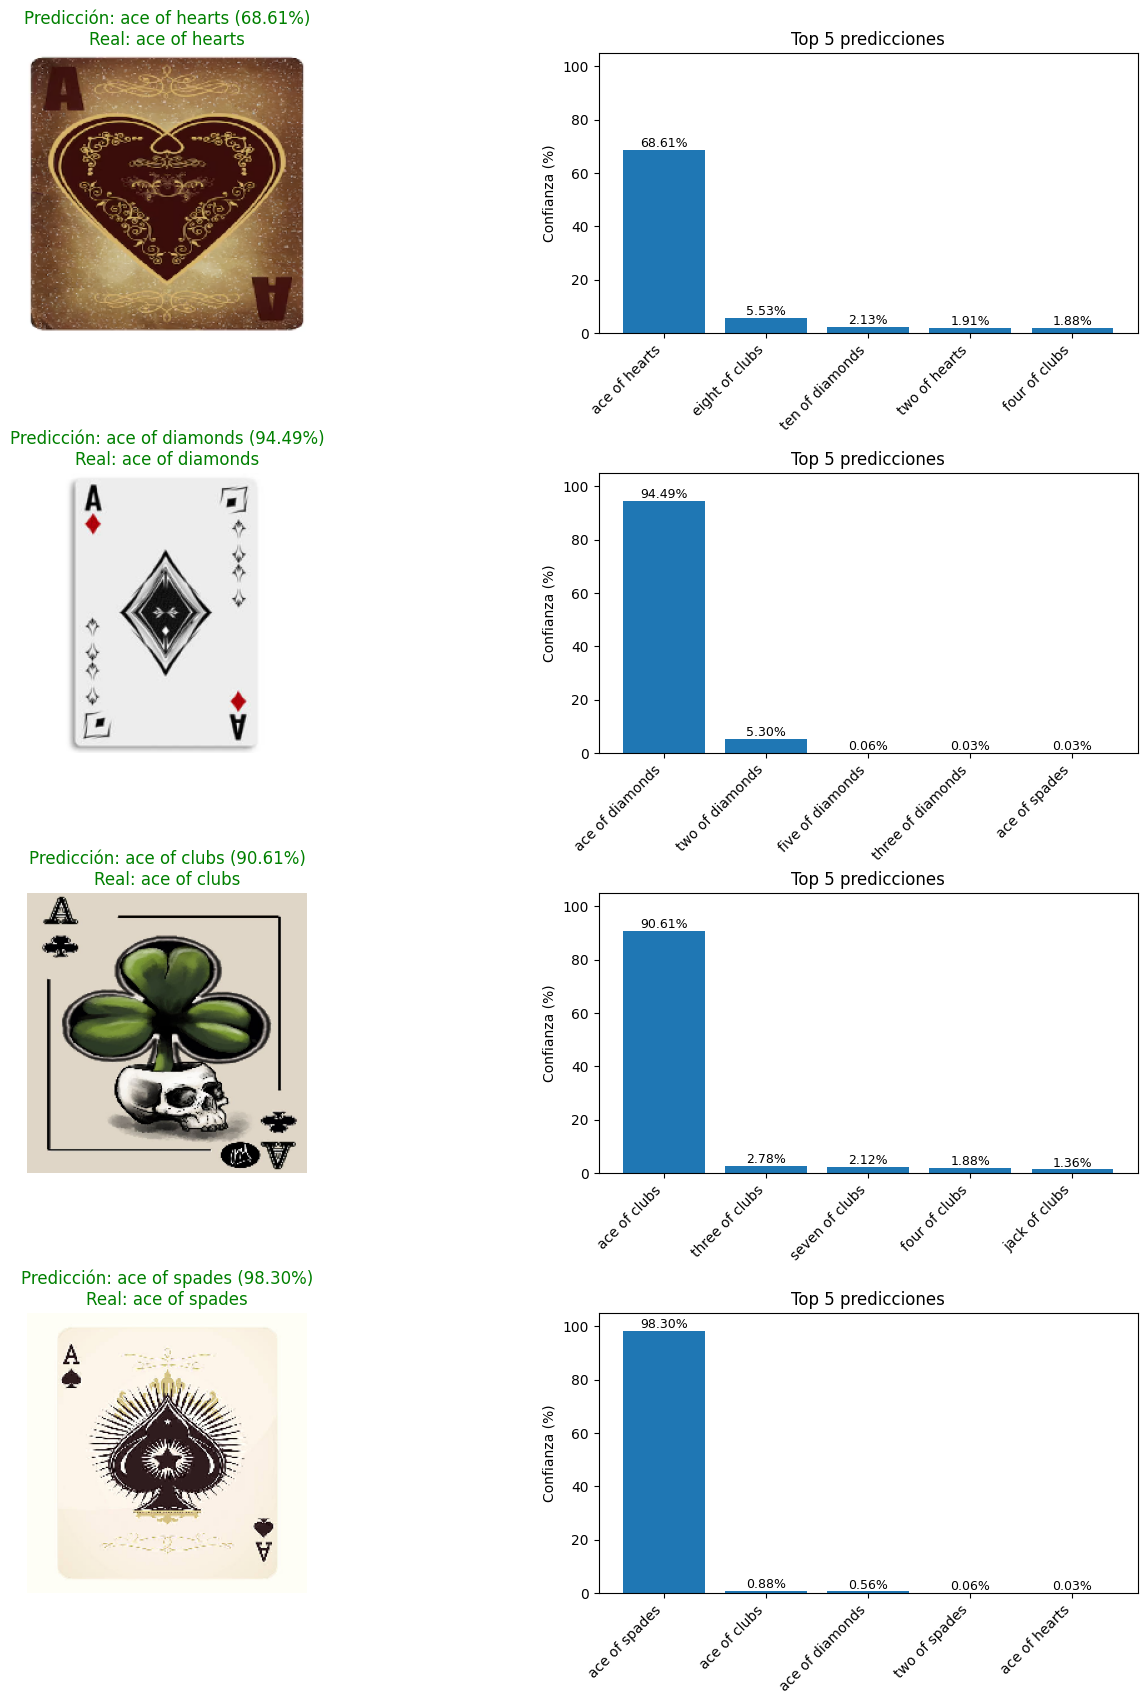

In [7]:
img_path_1 = [
    "/content/ah1.png",
    "/content/ad1.png",
    "/content/ac1.jpg",
    "/content/as1.jpg"
]

actual_classes_1 = [
    "ace of hearts",
    "ace of diamonds",
    "ace of clubs",
    "ace of spades"
]

predecir_varias(img_path_1, actual_classes_1)

### **3.2. Mismo palo con distintos valores**

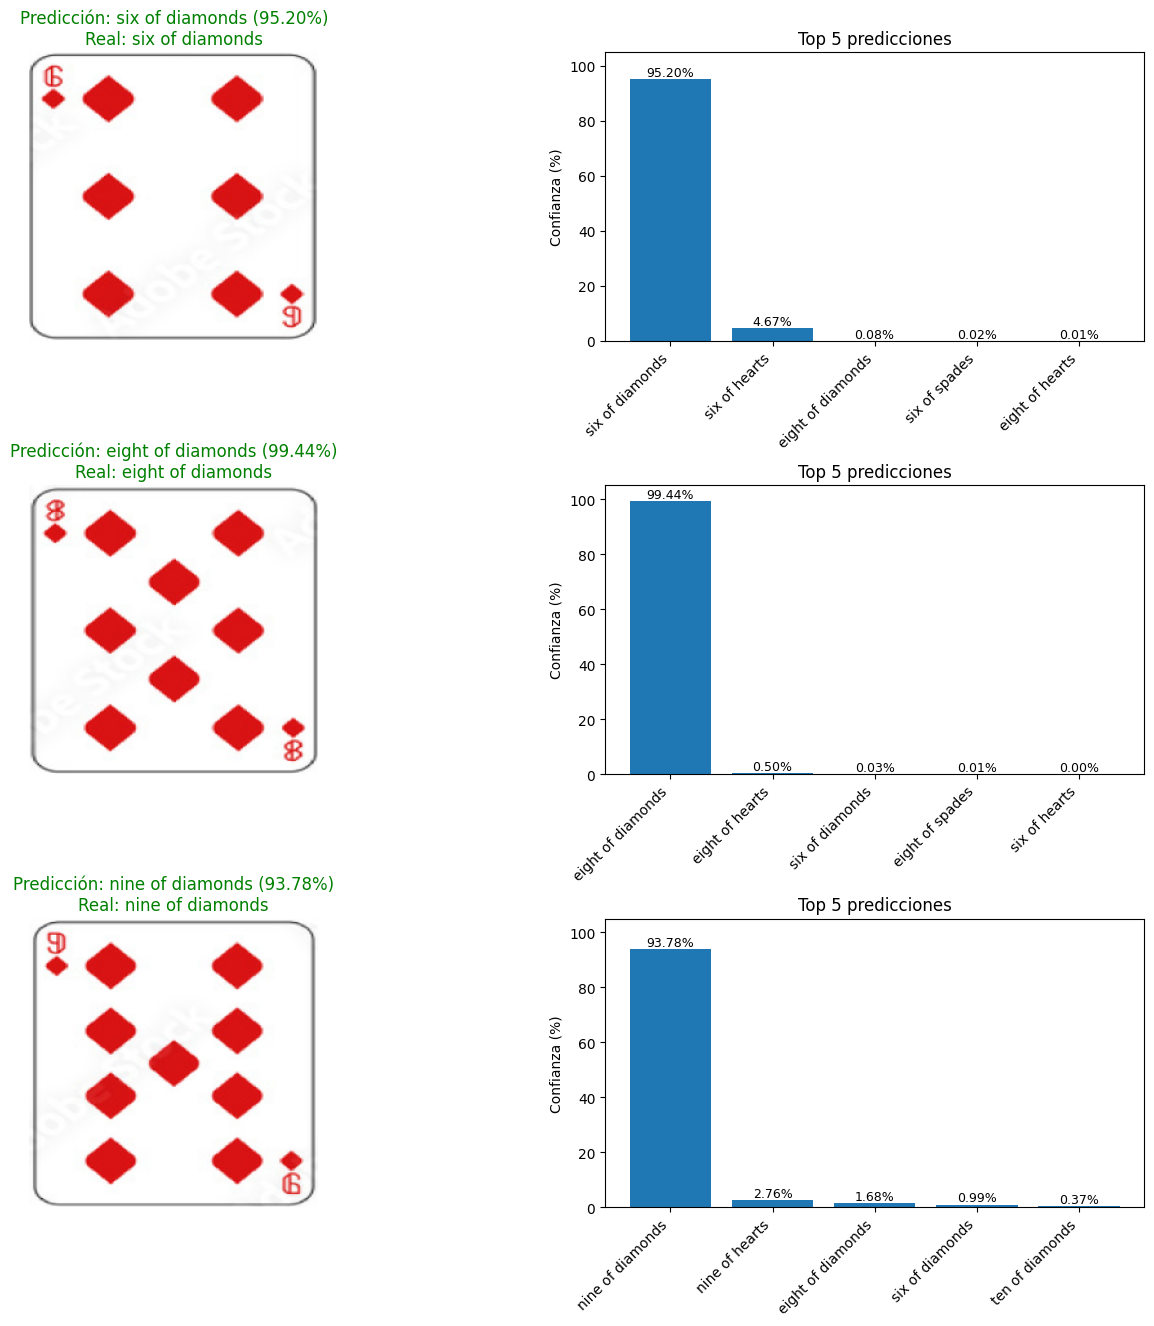

In [8]:
img_path_2 = [
    "/content/6d1.png",
    "/content/8d1.png",
    "/content/9d1.png"
]

actual_classes_2 = [
    "six of diamonds",
    "eight of diamonds",
    "nine of diamonds"
]

predecir_varias(img_path_2, actual_classes_2)

### **3.3. Joker**

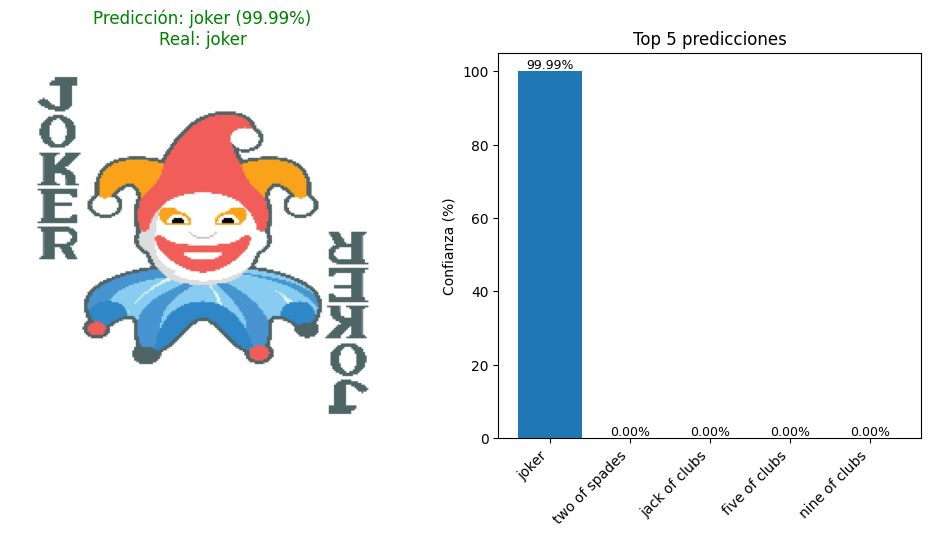

In [9]:
img_path_3 = "/content/j1.webp"
predecir_imagen_consola(img_path_3, actual_class="joker")

### **3.4. Imagen con rotación**

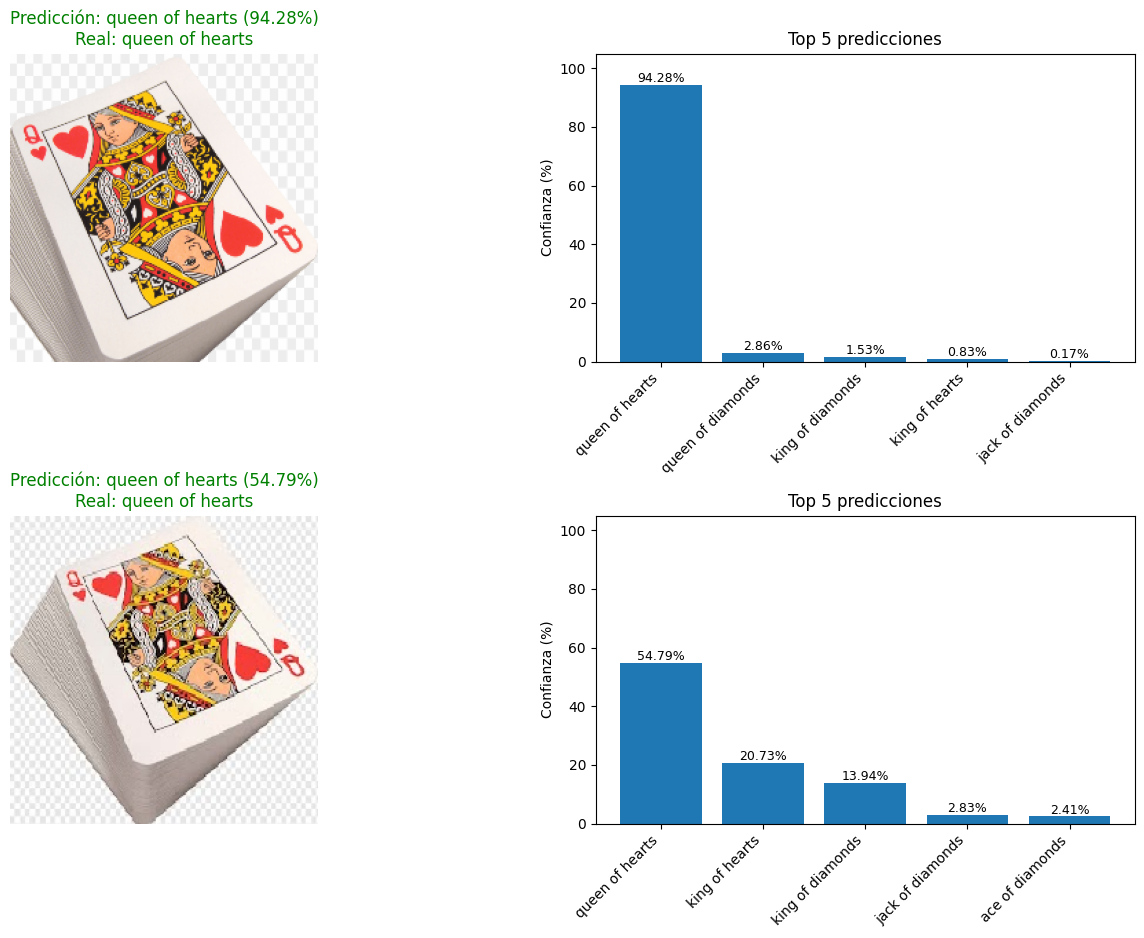

In [10]:
img_path_4 = ["/content/qh1.png",
              "/content/qh2.jpeg"]
actual_classes_5 = ["queen of hearts",
                   "queen of hearts"]
predecir_varias(img_path_4, actual_classes_5)

### **3.5. Imágenes muy similares al estándar**

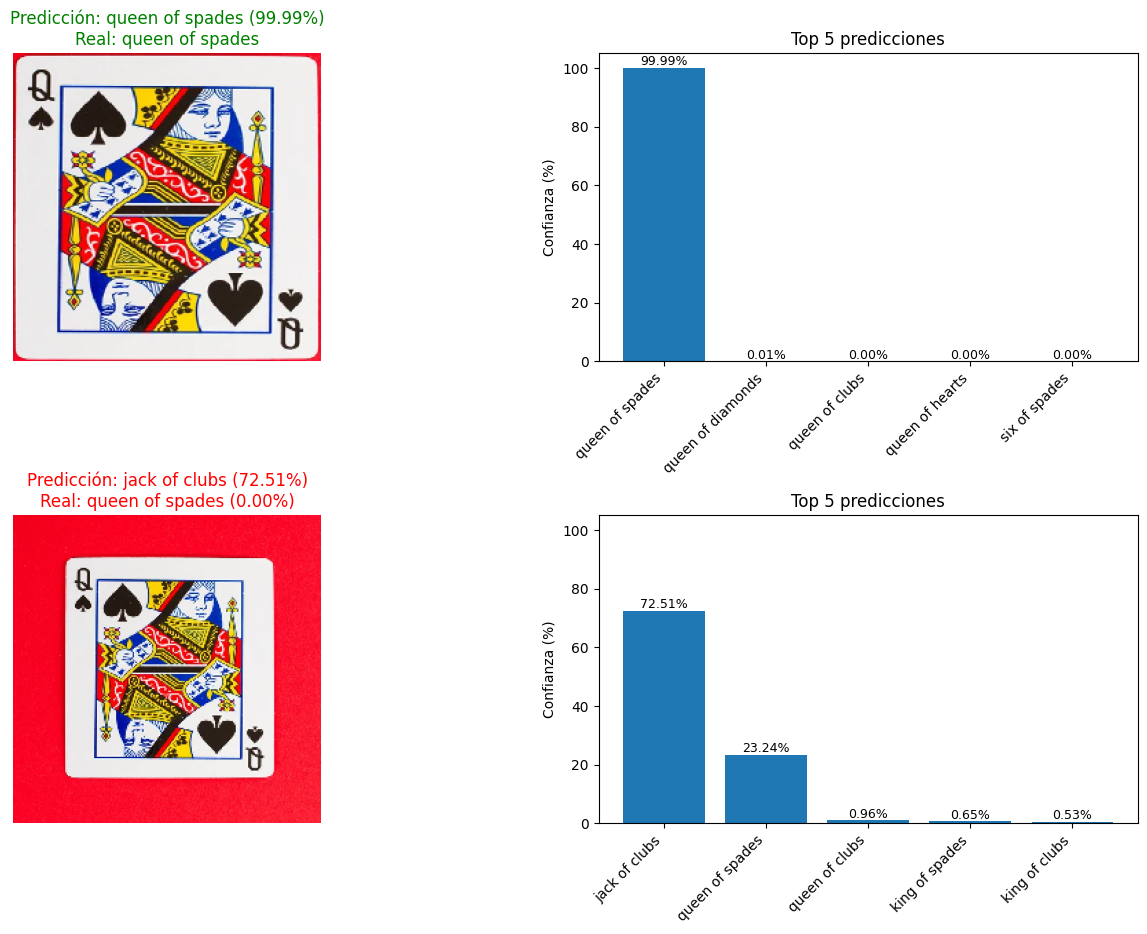

In [11]:
img_path_5 = ["/content/qs1.png",
              "/content/qs2.jpg"]
actual_classes_5 = ["queen of spades",
                         "queen of spades"]
predecir_varias(img_path_5, actual_classes_5)

### **3.6. Imágenes muy variables al estándar**

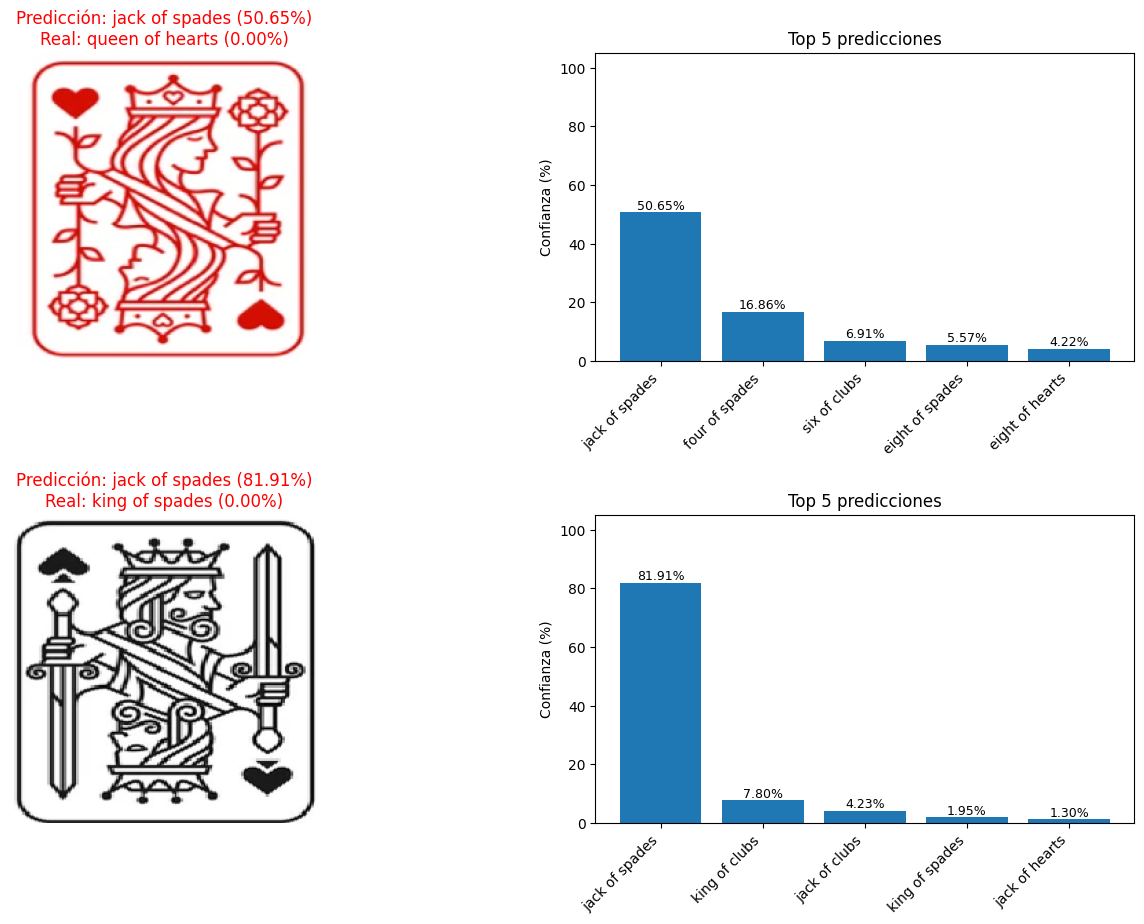

In [12]:
img_path_6 = ["/content/qh3.png",
              "/content/ks1.png"]
actual_classes_6 = ["queen of hearts",
                    "king of spades"]
predecir_varias(img_path_6, actual_classes_6)

### **3.7. Prueba**

Saving j5.jpg to j5 (1).jpg
Usuario ha subido el archivo 'j5 (1).jpg'


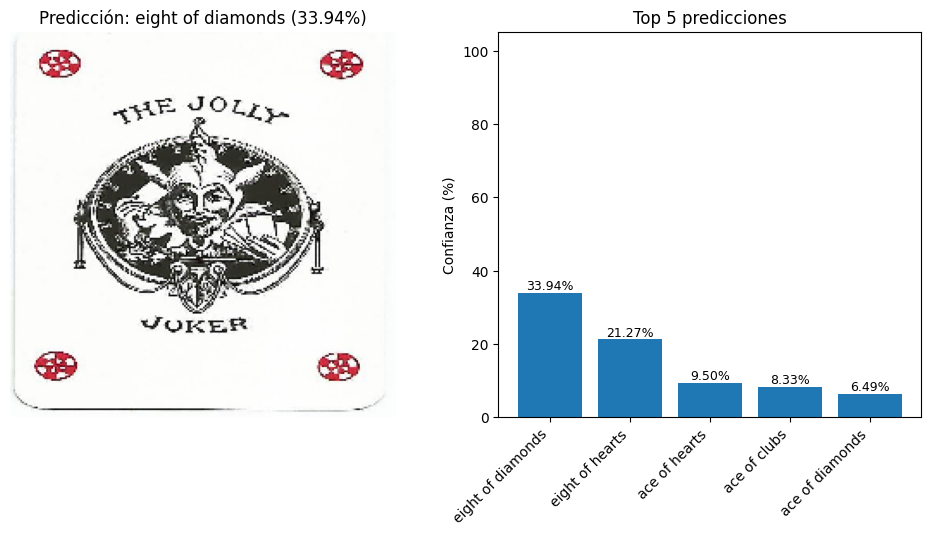

In [18]:
from google.colab import files

def upload_and_predict():
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f"Usuario ha subido el archivo \'{fn}\'")
        img_path = fn
        predecir_imagen_consola(img_path)

upload_and_predict()